In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tracker
import stats
import metrics
import visualizer
import utils

import importlib

def VISEM_to_Trackpy_Format(df):
    """Convert feature track IDs to a unique index."""
    ftid_map = {ftid: i for i, ftid in enumerate(df['ftid'].unique())}
    df['sperm'] = df['ftid'].map(ftid_map)

    # Convert 'frame' to integer type
    if 'frame' in df.columns:
        df['frame'] = df['frame'].astype(int)
    if 'sperm' in df.columns:
        df['sperm'] = df['sperm'].astype(int)

    # Turn x_center_pixel to x and y_center_pixel to y
    if 'x' not in df.columns or 'y' not in df.columns:
        df['x'] = df['x_center_pixel']
        df['y'] = df['y_center_pixel']

    return df

# Run Stats

In [21]:
prediction = "Comparisons_VISEM/12_yolo_bbox_data.csv"
groundtruth = "Comparisons_VISEM/12_corrected_with_trackpy.csv"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)

# Convert feature track IDs to unique sperm indices
pred_src = VISEM_to_Trackpy_Format(pred_src)
gt_src = VISEM_to_Trackpy_Format(gt_src)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)

# print(len(pred_src), len(gt_src), len(alt_src))
# print("Unique sperm in prediction source:", len(pred_src['sperm'].unique()))
# print("Unique sperm in ground truth source:", len(gt_src['sperm'].unique()))
# print("Unique sperm in alternative source:", len(alt_src['sperm'].unique()))

# print(len(pred), len(gt), len(alt))
# # Count number of unique sperm in each DataFrame
# print("Unique sperm in prediction:", len(pred['sperm'].unique()))
# print("Unique sperm in ground truth:", len(gt['sperm'].unique()))
# print("Unique sperm in alternative:", len(alt['sperm'].unique()))

In [22]:
# Compute stats for each file
ps = 1/0.833  # pixel size in micrometers
fps = 9  # frames per second
gt = stats.computeAllStats(gt_src,fps=fps,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred_src,fps=fps,pixel_size=ps,interpolate=False)

In [23]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction"], "VAP": [None], "VSL": [None], "VCL": [None], "ALH_mean": [None], "ALH_max": [None], "BCF": [None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])

# Print the EMD DataFrame
print(emd_df)

       Method       VAP       VSL        VCL ALH_mean ALH_max  BCF
0  Prediction  4.769535  0.280175  18.605641      NaN     NaN  NaN


In [24]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
})

print(summary_df)

print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Prediction  Ground Truth
0       VAP   42.491108     43.478199
1       VSL   69.055334     54.452506
2       VCL   74.051856    179.917293
3  ALH_mean  473.859881    444.365206
4   ALH_max  848.267029    809.983176
5       BCF    0.900000      0.803631
Mins: 0.0 0.044314937556856726 1.6546140116165058 0.6707262169777899 0.6991705457779653 0.0


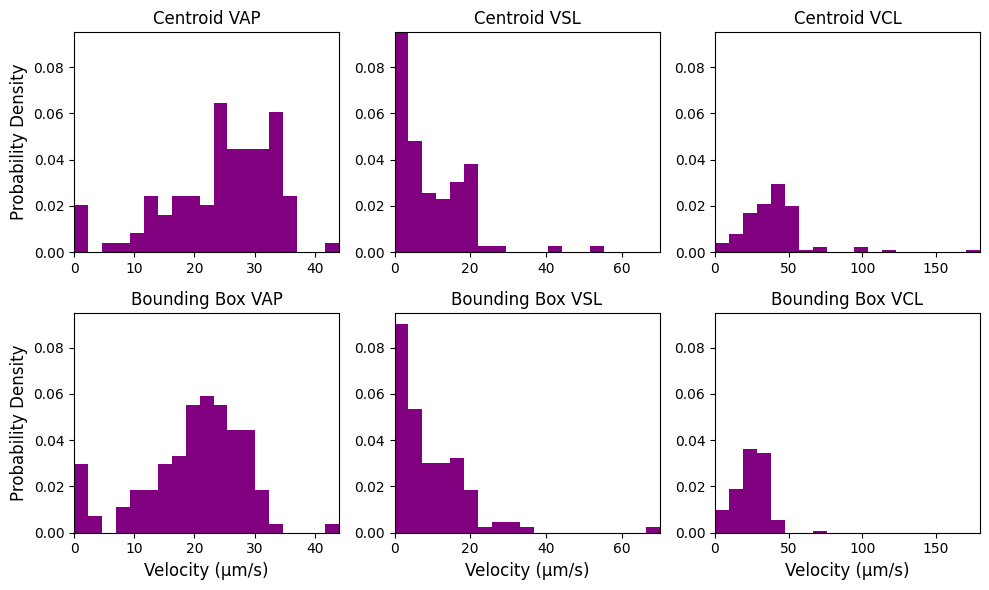

In [34]:
# Build 2x3 subplot for each stat and each method

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

import math
vap_max = math.ceil(max(gt_vap.max(), pred_vap.max()))
vsl_max = math.ceil(max(gt_vsl.max(), pred_vsl.max()))
vcl_max = math.ceil(max(gt_vcl.max(), pred_vcl.max()))

# Create horizontal violin plots for each stat and each method
# axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
# axs[0, 0].set_title('Ground Truth VAP')
# axs[1, 0].violinplot(gt_2s_vap, vert=False, showmeans=True)
# axs[1, 0].set_title('GT_2s VAP')
# axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
# axs[0, 1].set_title('Ground Truth VSL')
# axs[1, 1].violinplot(gt_2s_vsl, vert=False, showmeans=True)
# axs[1, 1].set_title('GT_2s VSL')
# axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
# axs[0, 2].set_title('Ground Truth VCL')
# axs[1, 2].violinplot(gt_2s_vcl, vert=False, showmeans=True)
# axs[1, 2].set_title('GT_2s VCL')

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)

# Create histograms for each stat and each method
axs[0, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[0, 0].set_title('Centroid VAP')
axs[1, 0].hist(pred_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[1, 0].set_title('Bounding Box VAP')
axs[0, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[0, 1].set_title('Centroid VSL')
axs[1, 1].hist(pred_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[1, 1].set_title('Bounding Box VSL')
axs[0, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[0, 2].set_title('Centroid VCL')
axs[1, 2].hist(pred_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[1, 2].set_title('Bounding Box VCL')


# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)

# Set y-limits for each subplot
axs[0, 0].set_ylim(0, 0.095)
axs[1, 0].set_ylim(0, 0.095)
axs[0, 1].set_ylim(0, 0.095)
axs[1, 1].set_ylim(0, 0.095)
axs[0, 2].set_ylim(0, 0.095)
axs[1, 2].set_ylim(0, 0.095)

# # Set colors of the bodies
# for ax in axs.flat:
#     for pc in ax.collections:
#         pc.set_facecolor('purple')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.7)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Probability Density', fontsize=12)
for ax in axs[1,:]:
    ax.set_xlabel('Velocity (µm/s)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

fig.savefig("experiment3.pdf", dpi=300)

## Compute stats for all VISEM videos

In [7]:
import pandas as pd
from scipy.stats import wasserstein_distance

video_ids = [11,12,13,14,15,19,21,22,23,24,29,30,35,36,38,47,52,54,60,82]

# Initialize an empty DataFrame for EMD results
emd_df = pd.DataFrame(columns=["Method", "VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"])

for video_id in video_ids:

    prediction = f"Comparisons_VISEM/{video_id}_yolo_bbox_data.csv"
    groundtruth = f"Comparisons_VISEM/{video_id}_corrected_with_trackpy.csv"

    # Load as Pandas DataFrame
    pred_src = utils.loadDataFrame(prediction)
    gt_src = utils.loadDataFrame(groundtruth)

    # Convert feature track IDs to unique sperm indices
    pred_src = VISEM_to_Trackpy_Format(pred_src)
    gt_src = VISEM_to_Trackpy_Format(gt_src)

    ps = 0.26  # pixel size in micrometers
    gt = stats.computeAllStats(gt_src,pixel_size=ps,interpolate=False)
    pred = stats.computeAllStats(pred_src,pixel_size=ps,interpolate=False)

    # Compute EMD for each statistic
    append_df = pd.DataFrame({"Method": [f"Video {video_id}"], "VAP": [None], "VSL": [None], "VCL": [None], "ALH_mean": [None], "ALH_max": [None], "BCF": [None]})
    for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
        append_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])

    emd_df = pd.concat([emd_df, append_df], ignore_index=True)

# Print the EMD DataFrame
print(emd_df)


KeyboardInterrupt: 

In [8]:
print(emd_df)

print(emd_df.describe())

# Get mean of each column other than Method
mean_values = emd_df.drop(columns=["Method"]).mean()
print("Mean values of EMD for each statistic:")
print(mean_values)


     Method       VAP       VSL        VCL ALH_mean ALH_max       BCF
0  Video 11  1.507517  0.037768  10.367828      NaN     NaN  0.354985
          Method       VAP       VSL        VCL ALH_mean ALH_max       BCF
count          1  1.000000  1.000000   1.000000        0       0  1.000000
unique         1  1.000000  1.000000   1.000000        0       0  1.000000
top     Video 11  1.507517  0.037768  10.367828      NaN     NaN  0.354985
freq           1  1.000000  1.000000   1.000000      NaN     NaN  1.000000
Mean values of EMD for each statistic:
VAP          1.507517
VSL          0.037768
VCL         10.367828
ALH_mean          NaN
ALH_max           NaN
BCF          0.354985
dtype: object


### Compute metrics of Trackpy on VISEM

In [28]:
import pandas as pd
from scipy.stats import wasserstein_distance
from tqdm import tqdm

importlib.reload(metrics)

video_ids = [11,12,13,14,15,19,21,22,23,24,29,30,35,36,38,47,52,54,60,82]

# Initialize an empty DataFrame for metric results
bbox_df = pd.DataFrame(columns=["Video", "DET", "LNK", "TRA", "TF", "MOTA", "IDF1", "HOTA"])
bbox_df_filter = pd.DataFrame(columns=["Video", "DET", "LNK", "TRA", "TF", "MOTA", "IDF1", "HOTA"])
gt_df = pd.DataFrame(columns=["Video", "DET", "LNK", "TRA", "TF", "MOTA", "IDF1", "HOTA"])
gt_df_filter = pd.DataFrame(columns=["Video", "DET", "LNK", "TRA", "TF", "MOTA", "IDF1", "HOTA"])

for video_id in tqdm(video_ids, desc="Processing videos"):

    prediction = f"Comparisons_VISEM/{video_id}.csv"
    groundtruth_bbox = f"Comparisons_VISEM/{video_id}_yolo_bbox_data.csv"
    groundtruth = f"Comparisons_VISEM/{video_id}_corrected_with_trackpy.csv"

    # Load as Pandas DataFrame
    pred_src = utils.loadDataFrame(prediction)
    gt_bbox_src = utils.loadDataFrame(groundtruth_bbox)
    gt_src = utils.loadDataFrame(groundtruth)

    # Convert feature track IDs to unique sperm indices
    gt_bbox_src = VISEM_to_Trackpy_Format(gt_bbox_src)
    gt_src = VISEM_to_Trackpy_Format(gt_src)

    # Make sure sperm and frame are int
    pred_src['sperm'] = pred_src['sperm'].astype(int)
    gt_bbox_src['sperm'] = gt_bbox_src['sperm'].astype(int)
    gt_src['sperm'] = gt_src['sperm'].astype(int)
    pred_src['frame'] = pred_src['frame'].astype(int)
    gt_bbox_src['frame'] = gt_bbox_src['frame'].astype(int)
    gt_src['frame'] = gt_src['frame'].astype(int)

    #results_bbox = metrics.computeMetrics(gt_bbox_src, pred_src, return_filtered=False)
    #results_gt = metrics.computeMetrics(gt_src, pred_src, return_filtered=False)

    results_bbox, results_bbox_filter = metrics.computeMetrics(gt_bbox_src, pred_src, return_filtered=True)
    results_gt, results_gt_filter = metrics.computeMetrics(gt_src, pred_src, return_filtered=True)

    # Append results to DataFrames
    bbox_df = pd.concat([bbox_df, pd.DataFrame({"Video": [video_id], "DET": [results_bbox['DET']], "LNK": [results_bbox['LNK']], "TRA": [results_bbox['TRA']], "TF": [results_bbox['TF']], 
                                                "MOTA": [results_bbox['MOTA']], "IDF1": [results_bbox['IDF1']], "HOTA": [results_bbox['HOTA']]
                                                })], 
                                                ignore_index=True)
    bbox_df_filter = pd.concat([bbox_df_filter, pd.DataFrame({"Video": [video_id], "DET": [results_bbox_filter['DET']], "LNK": [results_bbox_filter['LNK']], "TRA": [results_bbox_filter['TRA']], "TF": [results_bbox_filter['TF']], 
                                                              "MOTA": [results_bbox_filter['MOTA']], "IDF1": [results_bbox_filter['IDF1']], "HOTA": [results_bbox_filter['HOTA']]
                                                               })], ignore_index=True)
    gt_df = pd.concat([gt_df, pd.DataFrame({"Video": [video_id], "DET": [results_gt['DET']], "LNK": [results_gt['LNK']], "TRA": [results_gt['TRA']], "TF": [results_gt['TF']], 
                                            "MOTA": [results_gt['MOTA']], "IDF1": [results_gt['IDF1']], "HOTA": [results_gt['HOTA']]
                                            })], ignore_index=True)
    gt_df_filter = pd.concat([gt_df_filter, pd.DataFrame({"Video": [video_id], "DET": [results_gt_filter['DET']], "LNK": [results_gt_filter['LNK']], "TRA": [results_gt_filter['TRA']], "TF": [results_gt_filter['TF']], 
                                                          "MOTA": [results_gt_filter['MOTA']], "IDF1": [results_gt_filter['IDF1']], "HOTA": [results_gt_filter['HOTA']]
                                                          })], ignore_index=True)

# Print each DataFrame
print("BBox DataFrame:")
print(bbox_df)
print("\nBBox Filtered DataFrame:")
print(bbox_df_filter)
print("\nGround Truth DataFrame:")
print(gt_df)
print("\nGround Truth Filtered DataFrame:")
print(gt_df_filter)

Processing videos:   0%|          | 0/20 [00:00<?, ?it/s]/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_22102/1918130315.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bbox_df = pd.concat([bbox_df, pd.DataFrame({"Video": [video_id], "DET": [results_bbox['DET']], "LNK": [results_bbox['LNK']], "TRA": [results_bbox['TRA']], "TF": [results_bbox['TF']],
/var/folders/1h/phzg991d7bn15bphmc87wt680000gp/T/ipykernel_22102/1918130315.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bb

Warning removing unmatched frames for HOTA and IDF1 score.


Processing videos:  20%|██        | 4/20 [04:03<10:37, 39.85s/it]

Warning removing unmatched frames for HOTA and IDF1 score.


Processing videos:  40%|████      | 8/20 [11:18<16:37, 83.11s/it] 

Warning removing unmatched frames for HOTA and IDF1 score.
Warning removing unmatched frames for HOTA and IDF1 score.
Warning removing unmatched frames for HOTA and IDF1 score.


Processing videos:  45%|████▌     | 9/20 [11:23<10:48, 58.92s/it]

Warning removing unmatched frames for HOTA and IDF1 score.


Processing videos:  50%|█████     | 10/20 [14:43<17:02, 102.26s/it]

Warning removing unmatched frames for HOTA and IDF1 score.


Processing videos: 100%|██████████| 20/20 [26:31<00:00, 79.55s/it] 

BBox DataFrame:
   Video       DET       LNK       TRA        TF      MOTA      IDF1      HOTA
0     11  0.765933  0.881064  0.780937  0.604783 -0.365761  0.472199  0.527809
1     12  0.772777  0.747575  0.769498  0.391917  0.582849  0.526175  0.554675
2     13  0.854040  0.854522  0.854102  0.570456  0.779342  0.770174  0.760396
3     14  0.641671  0.974048  0.684973  0.748180 -2.374254  0.330932  0.424897
4     15  0.667948  0.881950  0.695821  0.826853 -1.269244  0.422331  0.499429
5     19  0.357601  0.846203  0.421246  0.448843 -4.239655  0.176141  0.282489
6     21  0.807791  0.917957  0.822130  0.653247 -0.250969  0.534425  0.574438
7     22  0.681338  0.958425  0.717407  0.763702 -1.834710  0.334079  0.433878
8     23  0.132600  0.866604  0.228056  0.880141 -6.469476  0.210072  0.341817
9     24  0.820692  0.844349  0.823775  0.511494  0.481437  0.599499  0.633486
10    29  0.507439  0.778613  0.542739  0.545393 -2.087310  0.310128  0.411064
11    30  0.800699  0.917564  0.8158

In [29]:
bbox_df.to_csv("bbox_metrics.csv", index=False)
bbox_df_filter.to_csv("bbox_metrics_filtered.csv", index=False)
gt_df.to_csv("gt_metrics.csv", index=False)
gt_df_filter.to_csv("gt_metrics_filtered.csv", index=False)

bbox_df.to_latex("bbox_metrics.tex", index=False, float_format="%.3f")
bbox_df_filter.to_latex("bbox_metrics_filtered.tex", index=False)
gt_df.to_latex("gt_metrics.tex", index=False, float_format="%.3f")
gt_df_filter.to_latex("gt_metrics_filtered.tex", index=False)